# 뉴스 요약봇 만들기📰

## 학습 목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

***

## 목차
- 텍스트 요약 개념 정리
- 추상적 요약
    - 데이터 수집
    - 데이터 전처리
    - 모델 설계 및 훈련
        - 어텐션 메커니즘 사용하기
    - 실제 결과와 요약문 비교하기
- 추출적 요약
- 추상적 요약과 추출적 요약 비교
- 프로젝트 정리

## 텍스트 요약(Text Summarization)이란?

- Document 원문을 핵심 주제만으로 구성된 짧은 Summary 문장들로 변화하는 것을 말한다.
-  예)뉴스 기사로 뉴스 제목 생성
- 요약 전후에 정보 손실 발생이 최소화 되어야 한다

### 추출적 요약(Extractive Summarization)
- 원문에서 __문장들을 추출__해서 요약하는 방식
- 예)10개의 문장으로 구성된 텍스트에서 핵심적인 문장 3개를 꺼내온다
- Text Classification 문제로 볼 수 있다
- 문장들 간의 호응이 자연스럽지 않을 수 있다
- 주로 ML인 텍스트 랭크(TextRank) 같은 알고리즘을 사용한다
- 사례)네이버 뉴스 서비스 요약봇

![요약봇](https://media.vlpt.us/images/dev_halo/post/fc1bf96f-0877-4db1-a4ee-a4a67f3e9c6c/20171128000144_0640.png)

### 추상적 요약(Abxtractive Summarization)
- 원문에서 내용이 요약된 __새로운 문장을 생성__하는 방식
- Natural Language Generation의 영역

### Seq2seq

- 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로 부터 출력 시퀀스를 생성해내는 모델
- 원문을 encoder(1st RNN)으로 입력하면 하나의 고정된 벡터로 변환(context vector)
- decoder(2nd RNN)은 context vector을 입력으로 받아 한 단어씩 생성해내서 요약 문장을 완성한다.

- encoder, decoder로 __LSTM__을 사용 → time step의 셀에 hidden state와 cell state가 함께 전달(context vector에도 hidden state와 cell state 모두 존재)
- 데이터의 예측 대상 시퀀스의 앞, 뒤에는 __시작 토큰과 종료 토큰__을 넣어주는 전처리를 해주어 어디서 멈춰야 하는지를 알려줄 필요가 있다.
- __Attention Mechanism__은 encoder의 모든 step의 hidden state의 정보가 context vector에 전부 반영되도록 하는 것
- decoder의 현재 스텝에 따라 동적으로 달라지는 encoder의 context vector를 사용해서 현재의 예측에 활용하면, decoder가 좀 더 정확한 예측을 할 수 있게 된다.

***

# 추상적 요약

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


## 1. 데이터 준비

- 사용 데이터: [New_Summary](https://github.com/sunnysai12345/News_Summary)
    - 데이터 세트는 4515개의 예시로 구성
    - Author_name, Headlines, Url of Article, Short text, Complete Article을 포함<br>(이 중 headlines, text만 사용)
    - 인쇼츠에서 요약된 뉴스를 모아서 힌두, 인디언 타임즈, 가디언 뉴스 기사만 스크랩
    - 기간: 2017년 2월부터 8월까지

In [2]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인
data.sample(10)

,headlines,text
71390,Surgical strike a message that we can cross Lo...,Lieutenant General Devraj Anbu on Thursday sai...
3394,Nearby galaxy to collide with Milky Way in 2.5...,Durham University astrophysicists have suggest...
36255,Rats 68% better at spotting TB than FDA-approv...,A Tanzania-based study found that rats can sni...
19006,"Eminem's rap song for 'Venom' mentions Gandhi,...",Rapper Eminem has mentioned Mahatma Gandhi and...
39612,Russian accidentally digs up bones of partner'...,"A Russian man, while digging a vegetable patch..."
61324,Over 900 booked for drunken driving in 20 hrs ...,Over 900 people were caught on Saturday for dr...
97979,"Who was Ashwin Sundar, the racer who died in a...","Professional car racer Ashwin Sundar, who died..."
97965,LG sued over flaw that made smartphones unusable,Electronics company LG has been sued by four G...
91032,"US families receive Iran payouts, decades afte...",American families of people killed in the 1983...
52381,Google Duo lets users call others who don't ha...,Google has launched an update for its video ch...


text를 본문, headlines를 요약된 데이터로 삼아 모델을 학습해본다,

In [4]:
data = data[['text', 'headlines']]
data.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

## 2. 데이터 전처리

### 2.1 중복 샘플 및 NULL 값 제거
신문기사 헤드라인의 경우 해당 사건의 요약문 이기 때문에 다른 샘플이어도 중복될 수 있다고 생각된다.그러나 text가 중복된 경우는 중복 샘플로 판단되므로 text의 중복샘플을 제거한다.

In [5]:
# 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 중복된 값 확인
for i in data.Summary[data['Summary'].duplicated()]:
    print(i)

Isha Ambani features on February cover of Vogue magazine
Indian Oil looking for annual deal to buy crude from US
David Beckham once scored a 60-yard goal from his own half
Sachin once fielded for Pakistan before making India debut
Iraq launches air strikes against ISIS in Syria
500-kg World War II bomb defused in Germany
Murali picked up 800th Test wicket on career's last ball
What is polar vortex, setting temperatures in US below Antarctica?
DMRC reserves 1st coach in all lines, except Red, for women
CARS24 enables car owners to sell their cars in less than 2 hours
Gautam Gambhir once gave his Man of the Match award to Virat Kohli
Pacer once took 7 wickets for just 1 run in 32 balls in a Test
Suzuki Connect helps you connect to your car seamlessly
Don Bradman once scored 100 runs in 3 overs
Indian spinner once bowled record 21 maiden overs in a row
Notice to Domino's for not passing GST benefit to customers
Mukesh Ambani's son Akash gets engaged to Shloka Mehta
World Cup's highest sco

In [7]:
# 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 데이터의 NULL값 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [9]:
## NULL값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.2 텍스트 정규화와 불용어 제거

__텍스트 정규화(Text normalization)__ : 같은 의미인데 다른 표현으로 쓰여 다른 단어로 간주되는 경우
학습전에 미리 같은 표현으로 통일 시켜주어 연산량을 줄인다.

In [10]:
# 텍스트 정규화를 위한 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


__불용어__: 텍스트에 자주 등장하지만 자연어 처리를 할 때 실질적으로 도움이 되지 않는 단어들

In [11]:
# LTK에서 제공하는 불용어 리스트를 참조
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# multiprocessing 으로훈련 데이터 전체에 대해서 전처리를 수행

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 불용어를 제거를 하지 않습니다.
print(clean_summary)

203.54169821739197  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

텍스트 정제 과정을 거친 후에는 빈 샘플이 생겼는지 확인해보는 게 좋다.

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
# 결측치 확인
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [275]:
# 정제과정에서 생긴 Null값 삭제
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


### 2.3 샘플의 최대 길이 정하기
Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해본다

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


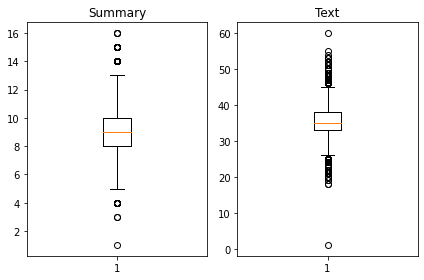

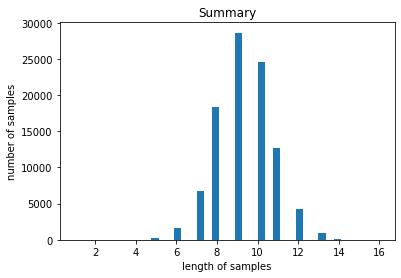

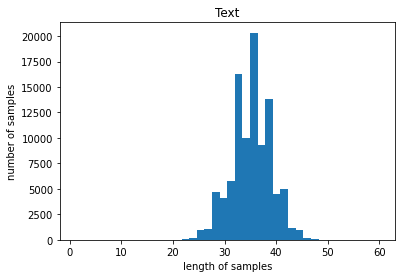

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정한다.
text_max_len = 40
summary_max_len = 11

In [19]:
# 최대 길이를 선택했을 때, 얼만큼의 샘플을 포함할 수 있는지 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [21]:
# 정해진 길이보다 길면 제외
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


### 2.4 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [23]:
# 인코더, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장한다.
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[83645 45374 11825 ... 38534 18249 46435]


In [25]:
#  정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
# 훈련 데이터와 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [27]:
# 훈련 데이터
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
# 테스트 데이터
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 2.5 정수 인코딩

- `src_tokenizer.word_index`: 단어 집합 저장
- `src_tokenizer.word_counts.items()`: 단어와 각 단어의 등장 빈도수가 저장

#### Text 데이터 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64668
등장 빈도가 9번 이하인 희귀 단어의 수: 47665
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17003
단어 집합에서 희귀 단어의 비율: 73.70724314962578
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.959937137116714


In [30]:
# 등장빈도가 9회 이하인 단어들은 훈련 데이터에서 제거
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

- `texts_to_sequences()`: 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[176, 19, 68, 2389, 368, 1616, 1918, 92, 848, 1610, 2580, 9182, 831, 116, 100, 1610, 2580, 9183, 2133, 710, 1988, 7284, 1164, 220, 14159, 1610, 33, 194, 69, 1515, 4783, 4240, 512], [151, 646, 2581, 32, 7637, 3842, 7637, 1567, 1175, 2967, 10307, 732, 3789, 37, 1404, 1567, 4833, 6, 828, 1921, 486, 4967, 2581, 171, 8795, 180, 7637, 6, 486, 8045, 2967, 10307, 1567, 732, 1921, 156, 252], [48, 11474, 9184, 80, 533, 13, 12260, 150, 13, 1660, 250, 566, 165, 158, 152, 5348, 9184, 96, 59, 4876, 366, 2, 14, 48, 10, 3704, 690, 1131, 12260, 13, 10, 1103]]


#### summary 정수 인코딩

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28507
등장 빈도가 5번 이하인 희귀 단어의 수: 18829
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9678
단어 집합에서 희귀 단어의 비율: 66.05044375065773
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.207025536816764


In [34]:
# 등장빈도가 5회 이하인 단어들은 훈련 데이터에서 제거
tar_vocab = 9700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 464, 2659, 7073, 6, 71, 3, 2917, 667, 794, 66], [1, 4410, 616, 5144, 317, 368, 82, 3725, 24, 102, 1056], [1, 7074, 5935, 471, 44, 385, 13, 7582], [1, 15, 3, 249, 1220, 10, 877, 54, 5367, 4563, 2250], [1, 51, 6, 37, 743, 4, 421, 77, 4735, 36]]
target
decoder  [[464, 2659, 7073, 6, 71, 3, 2917, 667, 794, 66, 2], [4410, 616, 5144, 317, 368, 82, 3725, 24, 102, 1056, 2], [7074, 5935, 471, 44, 385, 13, 7582, 2], [15, 3, 249, 1220, 10, 877, 54, 5367, 4563, 2250, 2], [51, 6, 37, 743, 4, 421, 77, 4735, 36, 2]]


In [35]:
# 빈도수가 낮은 단어가 삭제되어 생긴 빈 샘플 제거 (길이 1인 경우)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 2.6 padding
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해준다.

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 3. 모델 설계 및 훈련

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 3.1 encoder 설계

In [39]:
# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터의 차원
hidden_size = 256 # lstm에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 3.2 decoder 설계

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax') # tar_vocab에서 하나의 단어를 선택하는 다중 클래스 분류 문제
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3.3 Attention mechanism 설계

In [42]:
# 구현된 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [43]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3.4 모델 훈련

#### 모델 저장

In [44]:
checkpoint_path = "ex10/LSTM_AM.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

#### Early Stopping
모니터링 항목의 개선이 중지되면 학습을 중지하는 함수

|Args||
|------:|:---|
|monitor|모니터링 할 성능|
|patience|성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의|
|min_delta|개선의 자격을 갖추기 위해 모니터링되는 수량의 최소 변경, 즉 min_delta 미만의 절대 변경은 개선되지 않은 것으로 간주.|
|verbose|1 로 지정하면, 언제 keras 에서 training 을 멈추었는지를 화면에 출력|
|mode|{"auto", "min", "max"}, auto는 keras에서 알아서 min,max 선택,performance measure를 정의하고, 이것을 최대화 할지, 최소화 할지를 지정하는 것이다. 그러면 keras 에서 알아서 적절한 epoch 에서 training 을 멈춘다.|
|baseline|performance measure 를 practical 하게 설정한 경우 성능의 증가의 기준을 직접 정의. 모델이 기준선보다 개선되지 않으면 학습이 중지|
|restore_best_weights|모니터링된 수량의 최상의 값으로 에포크에서 모델 가중치를 복원할지 여부|

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
earlystopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[checkpoint ,earlystopping], epochs=50) # model.fit()에 callback으로 es객체를 넣어줘야 es 적용 가능

Epoch 1/50
269/269 [==============================] - 214s 750ms/step - loss: 6.3906 - val_loss: 5.6024

Epoch 00001: saving model to ex10/LSTM_AM.ckpt
Epoch 2/50
269/269 [==============================] - 207s 771ms/step - loss: 5.5276 - val_loss: 5.2340

Epoch 00002: saving model to ex10/LSTM_AM.ckpt
Epoch 3/50
269/269 [==============================] - 207s 769ms/step - loss: 5.1546 - val_loss: 4.9613

Epoch 00003: saving model to ex10/LSTM_AM.ckpt
Epoch 4/50
269/269 [==============================] - 207s 771ms/step - loss: 4.8443 - val_loss: 4.7305

Epoch 00004: saving model to ex10/LSTM_AM.ckpt
Epoch 5/50
269/269 [==============================] - 206s 765ms/step - loss: 4.6006 - val_loss: 4.5965

Epoch 00005: saving model to ex10/LSTM_AM.ckpt
Epoch 6/50
269/269 [==============================] - 205s 761ms/step - loss: 4.4051 - val_loss: 4.4578

Epoch 00006: saving model to ex10/LSTM_AM.ckpt
Epoch 7/50
269/269 [==============================] - 204s 759ms/step - loss: 4.2396 - v

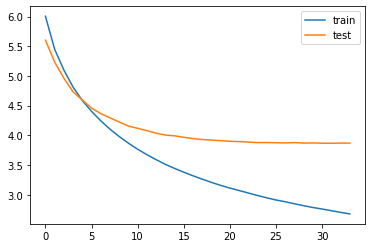

In [47]:
# 훈련 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Trial2 - padding이 'pre' 인 경우

In [78]:
# 패딩만 'pre'로 변경
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='pre')

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2176000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [79]:
checkpoint_path = "ex10/LSTM_AM2.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
earlystopping2 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history2 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[checkpoint2 ,earlystopping2], epochs=50) # model.fit()에 callback으로 es객체를 넣어줘야 es 적용 가능

Epoch 1/50
269/269 [==============================] - 202s 750ms/step - loss: 2.6508 - val_loss: 3.8785

Epoch 00001: saving model to ex10/LSTM_AM2.ckpt
Epoch 2/50
269/269 [==============================] - 202s 751ms/step - loss: 2.6240 - val_loss: 3.8859

Epoch 00002: saving model to ex10/LSTM_AM2.ckpt
Epoch 3/50
269/269 [==============================] - 201s 748ms/step - loss: 2.5992 - val_loss: 3.8807

Epoch 00003: saving model to ex10/LSTM_AM2.ckpt
Epoch 00003: early stopping


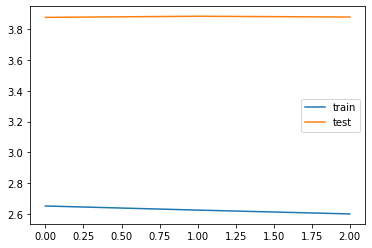

In [80]:
# 훈련 과정 시각화
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

'pre' padding으로 학습된 결과 심한..overfitting이 발생하였다. 때문에 'post' padding으로 진행된 모델을 가지고 테스트 결과를 살펴본다.

## 4. 모델 테스트

### 4.1 Inference Model 구현

> __Inference__? 학습을 마친 모델로 실제 과제를 수행하는 행위 혹은 그 과정

- Seq2seq는 훈련할 때와 인퍼런스 단계의 방식이 달라 그에 맞는 모델 설계를 별개로 진행해야 한다
- 훈련 단계: 인코더와 디코더를 엮은 모델 준비
- 인퍼런스 단계: 인코더 모델과 디코더 모델을 분리해서 설계(정답X, 디코더가 반복구조로 동작할 필요)

In [48]:
# 정수로 된 데이터를 실제로 복원해야 하므로 필요한 사전을 세팅한다.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
# 어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
# 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 4.2 원문과 요약문 비교

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [92]:
test_idx = np.random.randint(17168, size=10)

In [129]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50,100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bollywood actor shah rukh khan gave minute movie de india opening ceremony hockey world cup taking place bhubaneswar odisha tuesday ceremony also featured performance actor madhuri dixit odisha chief minister naveen patnaik shook hands captains participating nations 
실제 요약 : srk gives de india speech at hockey wc opening ceremony 
예측 요약 :  srk helps fans in opening final for world cup final


원문 : indian cricket team refused play day night test australian tour later year quality pink ball nobody put gun head say play said coa chief vinod rai earlier cricket australia ceo james sutherland claimed india reluctant day night test avoid loss 
실제 요약 : india refuse to play day night test during tour of australia 
예측 요약 :  team india team to play county cricket team


원문 : hearing kerala love jihad case underway supreme court judicial bench observed consent woman prime asserting law prohibits falling love criminal sc added national security threats state must take action individual rights

- 의미가 있는 문장도 나오지만, 같은 단어가 반복되어 예측되는 현상이 있다.
- 이는 어텐션 메커니즘이 출력 단어의 예측 시점 마다 입력되는 전체 문장 정보를 다시 검토하여 관련이 높은 입력 문장의 단어에 비중을 두어 출력 단어를 예측해주다보니 가중치가 높은 단어가 반복되어 출현하는 것으로 보인다.
- 이 문제는 RNN(LSTM)에서 토큰의 정보를 입력 어텐션으로 축척해가는 과정에서 각각의 단어에 다른 가중치를 부여하여 입력 어텐션 단어어 기여도를 조절해 해결할 수 있다고 한다.
- 실제 요약과는 전혀 다른 문장이지만 글의 의미를 잘 담겨낸 아주 새로운 문장을 잘 만든 경우도 있다.
    - 원문 : stanford researchers created fluid cooling panels covered optical surfaces reflect sunlight simultaneously heat atmosphere panels placed water pipes cooled water surrounding temperatures without using electricity placed building reduction electricity consumption observed 
    - 실제 요약 : system that works without electricity made 
    - 예측 요약 :  scientists create new fuel from water


# 추출적 요약

동일한 데이터를 가지고 summarize를 이용해 추출적 요약을 수행해본다.

In [207]:
import requests
from summa.summarizer import summarize
from summa import keywords

### summarize 사용하기

#### summa의 summarize()

|Args||
|:------|:---|
|text (str)|요약할 테스트|
|ratio (float, optional)|요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값|
|words (int or None, optional)|출력에 포함할 단어 수.만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.|
|split (bool, optional)|True면 문장 list / False는 조인(join)된 문자열을 반환|

* 내부적으로 문장토큰화 수행

In [238]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
# 내용 확인
data2.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [359]:
text = data2['text'].apply(str)

In [362]:
print('Summary:')
print(summarize(text.loc[93], ratio=0.4)) # 요약문으로 선택되는 문장의 개수, 원문의 0.4%만을 출력

Summary:
Television actor Karanvir Bohra, who flew to Russia on Tuesday to attend a film festival, has been detained in Moscow due to passport damage.


In [241]:
print('Summary:')
print(summarize(text.loc[1], words=20)) # 요약문으로 선택되는 문장의 개수, words 이상의 단어를 가지고 있는 문장 예측

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [243]:
def summarize_news(index, ratio):
    for i in index:
        print('[text]\n',text.iloc[i], '\n')
        print('[summary]\n',summarize(text.iloc[i], ratio=ratio),'\n')
        print('='*80)

In [244]:
summarize_news(range(50,100), 0.4)

[text]
 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets. 

[summary]
 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). 

[text]
 US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.  

[summary]
 Boeing r

- 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 비교적 낮다.
- 뉴스의 short text는 주로 앞 문장에서 주요한 정보를 먼저 전달해주는 경우가 많다보니 추출 요약 결과로도 첫 문장을 가져다 주는 경우가 많다.
- 네이버 요약봇도 위와 같은 결과를 뱉어주는 경우가 많은 것으로 보아 핵심적인 문장을 잘 추출한 것으로 판단된다.
- 요약문의 크기 조정시 단어수와 비율 모두 지정된 숫자보다 핵심 문장의 단어수/비율이 적으면 결과를 뱉어주지 않으므로 적절한 숫자 산정도 중요한 요소이다.

## 추상 요약 vs 추출 요약

|구분|문법|핵심단어|
|:---|:---|:---|
|추상요약|입력 어텐션의 어느 부분에 집중할지 매시점마다 예측하기 때문에 문법완성도가 떨어진다|Attention을 통해 중요 키워드 결정|
|추출요약|문장을 그대로 가져오기 때문에 문법 완성도가 높다.|TextRank를 이용해 중요 키워드 추출|

***

## 프로젝트 정리

- 연산량이 많아 모델이 학습되는 시간이 꽤 긴편인데 클라우드가 재부팅되면서 학습결과가 날아가는 경우가 발생했다. checkpoint를 이용해서 성능이 좋은 모델을 저장하게끔 하였다.
- 모델학습 결과 loss: 2.6338 - val_loss: 3.8690으로 loss가 꽤 높았고 과적합 되는 경향을 보였다. 시간상 이번에는 다양한 시도를 해보지 못했지만 dropout 등을 조정해 과적합을 해결해 봐야겠다.
- 관련해서 자료를 찾아보다가 lstm에는 'post' padding으로 학습하는 것이 결과가 좋다는 글을 읽어보았고, 동일하게 설계된 모델로 패딩순서만 변경하여 학습시켜봤는데 'pre' padding로 학습된 모델은 첫 epoch부터 과적합 양상을 보였고 그 정도가 'post' padding의 결과보다 컸다. 정보가 희석되지 않은채로 과하게 넘어가서 일까? 아직은 원인을 파악하기에 많이 부족하다..😥
- 추상 요약과 추출 요약을 비교하면서 텍스트 정규화와 불용어 처리를 하며 많은 정보량이 삭제된 것은 아닐까하는 생각이 들었다. 텍스트 요약에서는 문법적인 요소(부정어나 조사 등)를 포함해서 가르쳐줘야 더 자연스럽게 문장을 요약해주지 않을까 싶다.
- 프로젝트를 진행하면서 개념에 대한 이해가 부족하다보니 어떤 부분을 수정해서 더 좋은 결과를 낼 수 있을지 파악하기가 어려웠다. 하나씩 정리해나가야지..
- 어텐션과 양방향 LSTM이 번역에서 굉장히 성능이 좋았다고 한다! https://ratsgo.github.io/natural%20language%20processing/2017/10/22/manning/